<a href="https://colab.research.google.com/github/digdemorhan/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [ ]:
import pandas as pd
df = pd.read_csv('test.csv')
df.head()

,id,text,label
0,41993.0,@USER Sayın başkanım bu şekilde devam inşallah👏,0
1,23000.0,"Herkes gevşekliği kadar duyar kasıyor,hayat bö...",0
2,42478.0,Olgun ilişkisi olan arkadaş size en güzel hedi...,0
3,21748.0,@USER @USER Burada atıp tutacağına o kötü koşu...,1
4,13607.0,@USER İşte o onur dediğin sende yok sorun o işte,1


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8851 entries, 0 to 8850
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      5525 non-null   float64
 1   text    8851 non-null   object 
 2   label   8851 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 207.6+ KB
None


In [ ]:
df = df.drop(columns=['id'])
df.head()

,text,label
0,@USER Sayın başkanım bu şekilde devam inşallah👏,0
1,"Herkes gevşekliği kadar duyar kasıyor,hayat bö...",0
2,Olgun ilişkisi olan arkadaş size en güzel hedi...,0
3,@USER @USER Burada atıp tutacağına o kötü koşu...,1
4,@USER İşte o onur dediğin sende yok sorun o işte,1


**Buraya kadar olan kısımda CSV dosyası COLAB ortamına yüklenmiş, veri setinin ilk 5 elemanı yazdırılmış, veri setinin yapısı incelenmiş (sütun tipleri, NaN değer kontrolü) ve id sütunu veri setinde işe yaramayacak olup modelin eğitimini etkileyebileceğinden ve belirli noktalarda overfitting gibi bir durumla karşı karşıya bırakabileceğinden ötürü kaldırılmıştır.**

# **Preprocessing Steps**

In [ ]:
#Lower casing
df['text'] = df['text'].str.lower()
df.head()

,text,label
0,@user sayın başkanım bu şekilde devam inşallah👏,0
1,"herkes gevşekliği kadar duyar kasıyor,hayat bö...",0
2,olgun ilişkisi olan arkadaş size en güzel hedi...,0
3,@user @user burada atıp tutacağına o kötü koşu...,1
4,@user i̇şte o onur dediğin sende yok sorun o işte,1


In [ ]:
#Removal of emojis
import re
def remove_emojis(text):
    emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text'] = df['text'].apply(remove_emojis)

df.head(10)


,text,label
0,@user sayın başkanım bu şekilde devam inşallah,0
1,"herkes gevşekliği kadar duyar kasıyor,hayat bö...",0
2,olgun ilişkisi olan arkadaş size en güzel hedi...,0
3,@user @user burada atıp tutacağına o kötü koşu...,1
4,@user i̇şte o onur dediğin sende yok sorun o işte,1
5,@user @user düşük satsa sahip hacimli projeler...,0
6,@user ama alırken annem odaya girdi hay aq,1
7,@user yeniden yapılanma sezon içinde kadro dış...,0
8,@user günaydın melis hanım. hangi yaşta olursa...,0
9,@user tamamen senin şanssızlığın olmuş çoğu ki...,0


In [ ]:
#Removal of punctunations
df['text'] = df['text'].str.replace('[^\w\s]', '', regex=True)
df.head()

,text,label
0,user sayın başkanım bu şekilde devam inşallah,0
1,herkes gevşekliği kadar duyar kasıyorhayat böyle,0
2,olgun ilişkisi olan arkadaş size en güzel hediye,0
3,user user burada atıp tutacağına o kötü koşull...,1
4,user işte o onur dediğin sende yok sorun o işte,1


In [ ]:
#Removal of stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,label
0,user sayın başkanım şekilde devam inşallah,0
1,herkes gevşekliği kadar duyar kasıyorhayat böyle,0
2,olgun ilişkisi olan arkadaş size güzel hediye,0
3,user user burada atıp tutacağına kötü koşullar...,1
4,user işte onur dediğin sende yok sorun işte,1


**Bu bölümde bazı preprocessing adımları veri setinde uygulanmıştır. Bunlar:**
*   **Metinlerdeki tutarlılığı sağlamak için metinlerin tamamının küçük harfe dönüştürülmesi**
*   **Modelin metin anlamına odaklanması için emojilerin kaldırılması**
*   **Metnin anlamına katkı sağlamayan noktalama işaretlerinin öğrenme sürecini etkilememesi için çıkarılması**
*   **Veri setinin anlam yüklü kelimelerle beslenmesi için stopwords'lerin kaldırılması**

**Bu işlemler, modelin eğitimini etkileyebilecek gürültüleri ortadan kaldırmak ve doğruluk oranını artırmak için gerçekleştirilmiştir.**



# **GRU Model**

In [ ]:
#Etiket ataması
target = df['label'].values.tolist()
data = df['text'].values.tolist()

#Veri setinin 80-20 eğitim-test olarak ayrıştırılması
cutoff = int(len(data) * 0.80)

#Eğitim-test verilerinin belirlenmesi
x_train, x_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

#Eğitim veri setinden ve etiketten rastgele örnek alınması
print(x_train[505])
print(x_train[802])
print(y_train[802])

kafayı sıyırmış kadar insan var nöbetten çıktığım hiçbiri anormal gelmiyor yoksa
şimdi bilsen kadar özledim seni dinle artık geç kalan sözlerimi kaybetmekmiş susmanın bedeli duy artık seviyorum seni
0


In [ ]:
#Gerekli kütüphanelerin eklenmesi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Metin verisinin sayısal verilere dönüştürülmesi
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data)
tokenizer.word_index

{'user': 1,
 'bir': 2,
 'amk': 3,
 'aq': 4,
 'var': 5,
 'ben': 6,
 'bi': 7,
 'kadar': 8,
 'yok': 9,
 'mi': 10,
 'sen': 11,
 'değil': 12,
 'senin': 13,
 'seni': 14,
 'sonra': 15,
 'iyi': 16,
 'bile': 17,
 'koduğumun': 18,
 'böyle': 19,
 'olsun': 20,
 'güzel': 21,
 'amq': 22,
 'amına': 23,
 'artık': 24,
 'sana': 25,
 'lan': 26,
 'sizin': 27,
 'zaten': 28,
 'olan': 29,
 'olur': 30,
 'adam': 31,
 'benim': 32,
 'zaman': 33,
 'bak': 34,
 'yine': 35,
 'bana': 36,
 'olarak': 37,
 'oldu': 38,
 'allah': 39,
 'şimdi': 40,
 'amını': 41,
 'tek': 42,
 'önce': 43,
 'insan': 44,
 'bunu': 45,
 'öyle': 46,
 'beni': 47,
 'git': 48,
 '2': 49,
 'gün': 50,
 'sizi': 51,
 'kendi': 52,
 'sadece': 53,
 'başka': 54,
 'bizim': 55,
 'hala': 56,
 'falan': 57,
 'ulan': 58,
 'kodugumun': 59,
 'bunlar': 60,
 '1': 61,
 'büyük': 62,
 'işte': 63,
 'size': 64,
 'salağı': 65,
 'bize': 66,
 'aynı': 67,
 'türk': 68,
 'iki': 69,
 'olsa': 70,
 'son': 71,
 'çocuğu': 72,
 'orospu': 73,
 'para': 74,
 'biraz': 75,
 'kadını': 76,
 

In [ ]:
#Eğitim verisinin tokenize edilmesi
x_train_tokens = tokenizer.texts_to_sequences(x_train)

#Örnek alınması
x_train[789]

'boş davadosyası emniyet yargı içine sızmış karanlık kripto yapının dava ilgili türlü gayrı meşru yola tevessül edebilecek son derece gözü dönmüş kin nefret öfke hasetle hareket eden pervasız düşük ahlaklıhukuk tanımaz bir güruh olduğunu ortaya koymaktadır'

In [ ]:
#Alınan örneğin sayısal karşılığı
print(x_train_tokens[789])

[117, 3173, 647, 2214, 3991, 1765, 285, 363, 5225, 7641, 1731, 71, 2535, 1158, 7642, 2282, 296, 778, 136, 1327, 2, 2283, 130, 445]


In [ ]:
import numpy as np

#Test verisinin tokenize edilmesi
x_test_tokens = tokenizer.texts_to_sequences(x_test)

#x_train ve x_test verilerindeki tüm token sayılarının birleştirilmesi ve dizi formatına getirilmesi
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

#Tüm tokenların ortalaması
print(np.mean(num_tokens))

#En fazla token'a sahip örneğin token sayısı
print(np.max(num_tokens))

#En fazla token'a sahip örneğin indexi
print(np.argmax(num_tokens))

10.394079764998306
53
169


In [ ]:
#Ortalama token sayısının 2 katı std eklenerek max token sayısının hesaplanması
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

23

**Bu işlem, uzun metinlerin modeli etkilememesi için gerçekleştirilmiştir.**

In [ ]:
#Max_tokens'tan daha kısa olan metinlerin oranının hesaplanması
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.930064399502881

**Bu işlem, hangi metin uzunluklarının daha yaygın olduğunun anlaşılmasına yardımcı olur.**

In [ ]:
#Tüm metinlerin eşit uzunluğa getirilmesi
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

#Eğitim ve test verisinin boyutlarının alınması
print(x_train_pad.shape)
print(x_test_pad.shape)

(7080, 23)
(1771, 23)


In [ ]:
#789. örneğin token dizisi
np.array(x_train_tokens[789])

array([ 117, 3173,  647, 2214, 3991, 1765,  285,  363, 5225, 7641, 1731,
         71, 2535, 1158, 7642, 2282,  296,  778,  136, 1327,    2, 2283,
        130,  445])

In [ ]:
#789. örneğin pad'lenmiş formu
x_train_pad[789]

array([3173,  647, 2214, 3991, 1765,  285,  363, 5225, 7641, 1731,   71,
       2535, 1158, 7642, 2282,  296,  778,  136, 1327,    2, 2283,  130,
        445], dtype=int32)

In [ ]:
#Token dizisinin tekrardan metne dönüştürülmesi
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [ ]:
#Kelimelerin metne dönüştürülmesi
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

x_train[789]

#789. örneğin token dizisinden geri döndürülen metnin çıktısı
tokens_to_string(x_train_tokens[789])

'boş yargı içine karanlık kripto dava ilgili türlü gayrı meşru yola son derece gözü dönmüş kin nefret hareket eden düşük bir güruh olduğunu ortaya'

In [ ]:
#Keras Sequential API ile modelin hazırlanması
model = Sequential()
embedding_size = 50
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))

model.add(GRU(units=64, return_sequences=True, input_shape=(max_tokens,)))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-3)

#Modelin çalışmasının test edilmesi için 0'lardan oluşan giriş verisinin modele verilmesi
dummy_input = np.zeros((1, max_tokens))
model(dummy_input)

#Modelin derlenmesi
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

#Modelin özeti
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ (1, 23, 50)                 │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (1, 23, 64)                 │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (1, 23, 32)                 │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (1, 16)                     │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,097 (2.04 MB)

 Trainable params: 534,097 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Modelin eğitimi
y_train = np.array(y_train)

model.fit(
    x_train_pad,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7753 - loss: 0.5446 - val_accuracy: 0.0742 - val_loss: 1.1064
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8558 - loss: 0.3359 - val_accuracy: 0.9103 - val_loss: 0.2188
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9605 - loss: 0.1241 - val_accuracy: 0.9350 - val_loss: 0.1932
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9849 - loss: 0.0517 - val_accuracy: 0.9400 - val_loss: 0.2023
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9948 - loss: 0.0232 - val_accuracy: 0.9357 - val_loss: 0.2408
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9948 - loss: 0.0188 - val_accuracy: 0.9407 - val_loss: 0.2246
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9969 - loss: 0.0118 - val_accuracy: 0.9371 - val_loss: 0.2901
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9983 - loss: 0.0091 - val_accuracy: 0.9018 - val_loss

In [ ]:
#Modelin doğruluk loss ve accuracy değerlerinin görüntülenmesi
import tensorflow as tf

result = model.evaluate(tf.convert_to_tensor(x_test_pad), tf.convert_to_tensor(y_test))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9501 - loss: 0.2400


In [ ]:
#Modelin test verisi üzerindeki doğruluk değeri
result[1]

0.9553924202919006

In [ ]:
#Modelin test verisi üzerindeki kayıp değeri
result[0]

0.22450941801071167

In [ ]:
#Modelin test verisi üzerindeki tahminlerinin alınması
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

#Tahmin sonuçlarının 0.5 eşik değerine göre sınıflandırılması
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

#Gerçek ile tahmin sınıflandırılmasının karşılaştırılması
cls_true = np.array(y_test[0:1000])

#Yanlış sınıflandırılan örneklerin indexleri
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

#Yanlış sınıflandırılan örnek sayısı
len(incorrect)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


47

In [ ]:
#Yanlış sınıflandırılmış örneğin indexi
idx = incorrect[0]
idx

8

In [ ]:
#Yanlış sınıflandırılan örnek
text = x_test[idx]
text

'medbutsanane ilk bölümde ahmet abi yok oluyodu aq babası halitti soniaya aşık olmak yerine esraya aşık oluyodu sonra ahmet abi soniaya halit içecek istiyo deyip halitin üstüne içki döktürüyodu ahmet abinin elindeki yok olma geçiyodu burda düşünür insan müneccim olmaya gerek yok tşk'

In [ ]:
#Yanlış sınıflandırılan örneğin tahmin edildiği değer
y_pred[idx]

0.23941047

In [ ]:
#Yanlış sınıflandırılan örneğin gerçek sınıfı
cls_true[idx]

1

In [ ]:
#Örnek veriler üzerinde modelin test edilmesi
text1 = "gerizekalı ordularıyla aynı platformda olmak can sıkıcı"
text2 = "seni ciddi manada tebrik ediyorum"
text3 = "hakaretimi bile hak etmezsiniz neyse sinirlenmicem favlayın"
text4 = "harika düşünce sisteminiz var geleceğin aydın yüzüsünüz"
text5 = "aptallık akıyor suratından rezilsin"

texts = [text1, text2, text3, text4, text5]

tokens = tokenizer.texts_to_sequences(texts)

tokens_pad = pad_sequences(tokens, maxlen=max_tokens)

print(tokens_pad.shape)

model.predict(tokens_pad)

(5, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.99713314],
       [0.00167695],
       [0.51580614],
       [0.03985808],
       [0.96711606]], dtype=float32)

**Buradan da görüldüğü üzere ofansif veriler 1, normal olanlar 0 etiketine sahiptir. Modelin örnek veriler üzerindeki tahminine bakıldığında doğru şekilde tahmin edip sınıflandırdığı görülmektedir.**

# **LSTM MODEL**

In [ ]:
from tensorflow.keras.layers import LSTM

#LSTM modelinin oluşturulması
lstm_model = Sequential()
embedding_size = 50
lstm_model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))

lstm_model.add(LSTM(units=32, return_sequences=True, input_shape=(max_tokens)))
lstm_model.add(LSTM(units=16, return_sequences=True))
lstm_model.add(LSTM(units=16))
lstm_model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-3)

#Modelin çalışmasının test edilmesi için 0'lardan oluşan giriş verisinin modele verilmesi
dummy_input_lstm = np.zeros((1, max_tokens))
lstm_model(dummy_input_lstm)

#Modelin derlenmesi
lstm_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

#Modelin özeti
lstm_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ (1, 23, 50)                 │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (1, 23, 32)                 │          10,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (1, 23, 16)                 │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (1, 16)                     │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 1)                      │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,889 (1.97 MB)

 Trainable params: 515,889 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_train = np.array(y_train)

#Modelin eğitimi
lstm_model.fit(
    x_train_pad,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7553 - loss: 0.5634 - val_accuracy: 0.0000e+00 - val_loss: 1.5335
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7989 - loss: 0.4743 - val_accuracy: 0.5621 - val_loss: 0.7557
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9042 - loss: 0.2787 - val_accuracy: 0.8305 - val_loss: 0.4496
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9603 - loss: 0.1323 - val_accuracy: 0.8814 - val_loss: 0.3510
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9812 - loss: 0.0676 - val_accuracy: 0.9082 - val_loss: 0.3206
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9906 - loss: 0.0373 - val_accuracy: 0.9117 - val_loss: 0.3286
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9923 - loss: 0.0260 - val_accuracy: 0.9160 - val_loss: 0.3311
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9979 - loss: 0.0137 - val_accuracy: 0.9096 - val_

In [ ]:
import tensorflow as tf

#Modelin accuracy ve loss değerlerinin alınması
result_lstm = model.evaluate(tf.convert_to_tensor(x_test_pad), tf.convert_to_tensor(y_test))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9501 - loss: 0.2400


In [ ]:
#Modelin test verisi üzerindeki doğruluk değeri
result_lstm[1]

0.9553924202919006

In [ ]:
#Modelin test verisi üzerindeki kayıp değeri
result_lstm[0]

0.22450941801071167

In [ ]:
#Modelin test verisi üzerindeki tahminlerinin alınması
y_pred = lstm_model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

#Tahmin sonuçlarının 0.5 eşik değerine göre sınıflandırılması
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

#Gerçek ile tahmin sınıflandırılmasının karşılaştırılması
cls_true = np.array(y_test[0:1000])

#Yanlış sınıflandırılan örneklerin indexleri
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

#Yanlış sınıflandırılan örnek sayısı
len(incorrect)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


87

In [ ]:
#Yanlış sınıflandırılmış örneğin indexi
idx = incorrect[0]
idx

8

In [ ]:
#Yanlış sınıflandırılan örnek
text = x_test[idx]
text

'medbutsanane ilk bölümde ahmet abi yok oluyodu aq babası halitti soniaya aşık olmak yerine esraya aşık oluyodu sonra ahmet abi soniaya halit içecek istiyo deyip halitin üstüne içki döktürüyodu ahmet abinin elindeki yok olma geçiyodu burda düşünür insan müneccim olmaya gerek yok tşk'

In [ ]:
#Yanlış sınıflandırılan örneğin tahmin edildiği değer
y_pred[idx]

0.0014107063

In [ ]:
#Yanlış sınıflandırılan örneğin gerçek sınıfı
cls_true[idx]

1

In [ ]:
#Örnek veriler üzerinden modelin test edilmesi
text1 = "gerizekalı ordularıyla aynı platformda olmak can sıkıcı"
text2 = "seni ciddi manada tebrik ediyorum"
text3 = "hakaretimi bile hak etmezsiniz neyse sinirlenmicem favlayın"
text4 = "harika düşünce sisteminiz var geleceğin aydın yüzüsünüz"
text5 = "aptallık akıyor suratından rezilsin"

texts = [text1, text2, text3, text4, text5]

tokens = tokenizer.texts_to_sequences(texts)

tokens_pad = pad_sequences(tokens, maxlen=max_tokens)

print(tokens_pad.shape)
lstm_model.predict(tokens_pad)

(5, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.99727887],
       [0.0010089 ],
       [0.01488993],
       [0.95990556],
       [0.49466068]], dtype=float32)

**Yukarıdaki örneğe bakıldığında 0 değeri ofansif, 1 değeri normali göstermektedir. GRU modeline kıyasla daha yanlış sonuçlar verme eğilimde olan LSTM modeli, bazı örneklerin sınıflandırılmasında hata yapmaktadır.**

# **LSTM And GRU Comparison**

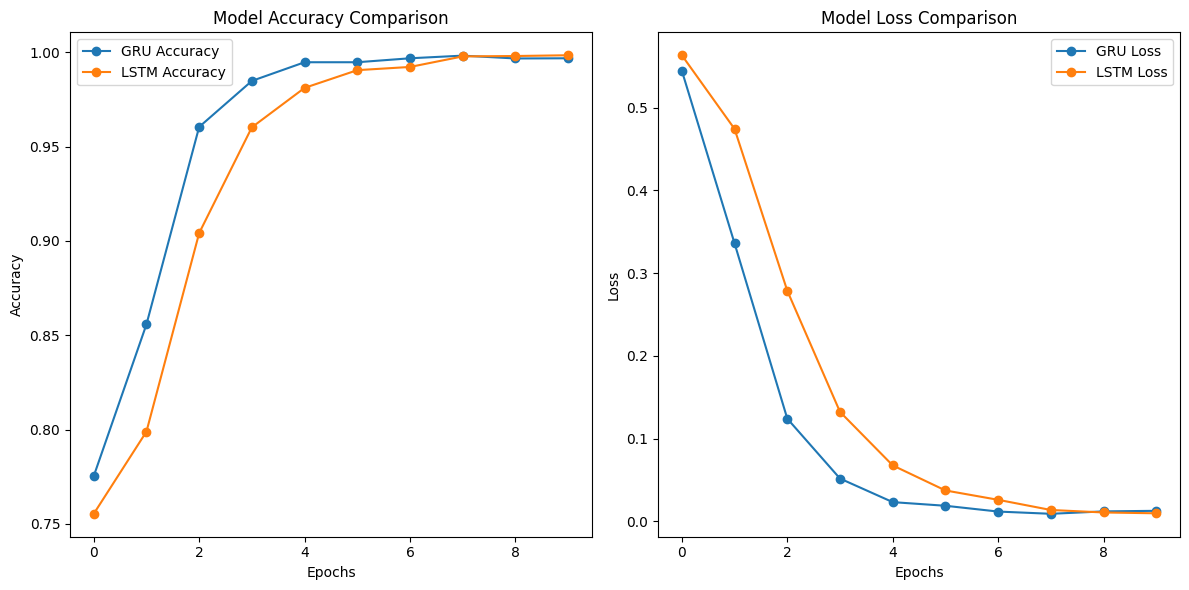

In [ ]:
import matplotlib.pyplot as plt

#Grafik üzerinde LSTM ve GRU karşılaştırması
gru_acc = [0.7753, 0.8558, 0.9605, 0.9849, 0.9948, 0.9948, 0.9969, 0.9983, 0.9968, 0.9969]  # GRU Doğruluk
gru_loss = [0.5446, 0.3359, 0.1241, 0.0517, 0.0232, 0.0188, 0.0118, 0.0091, 0.0120, 0.0127]  # GRU Kayıp

lstm_acc = [0.7553, 0.7989, 0.9042, 0.9603, 0.9812, 0.9906, 0.9923, 0.9979, 0.9981, 0.9985]  # LSTM Doğruluk
lstm_loss = [0.5634, 0.4743, 0.2787, 0.1323, 0.0676, 0.0373, 0.0260, 0.0137, 0.0107, 0.0097]  # LSTM Kayıp

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(gru_acc, label="GRU Accuracy", marker='o')
plt.plot(lstm_acc, label="LSTM Accuracy", marker='o')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_loss, label="GRU Loss", marker='o')
plt.plot(lstm_loss, label="LSTM Loss", marker='o')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

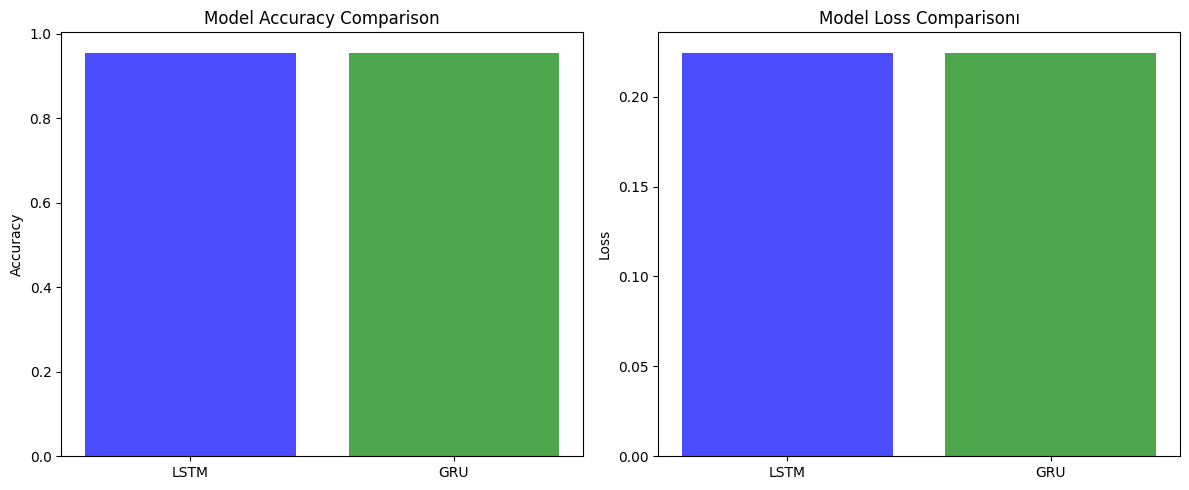

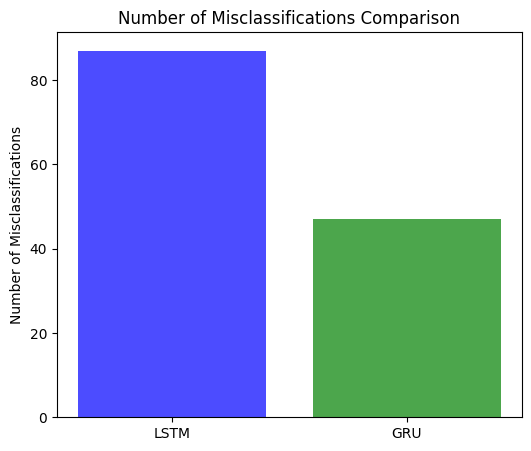

In [ ]:
import matplotlib.pyplot as plt

#modellerin doğruluk ve kayıp değerleri
lstm_accuracy = 0.9553924202919006
gru_accuracy = 0.9553924202919006
lstm_loss = 0.22450941801071167
gru_loss = 0.22450941801071167

#modellerin yanlış sınıflandırma sayıları
lstm_incorrect = 87
gru_incorrect = 47

accuracies = [lstm_accuracy, gru_accuracy]
losses = [lstm_loss, gru_loss]
incorrect_classifications = [lstm_incorrect, gru_incorrect]

labels = ['LSTM', 'GRU']

x = range(len(labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(x, accuracies, color=['blue', 'green'], alpha=0.7)
plt.xticks(x, labels)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.bar(x, losses, color=['blue', 'green'], alpha=0.7)
plt.xticks(x, labels)
plt.ylabel('Loss')
plt.title('Model Loss Comparisonı')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.bar(x, incorrect_classifications, color=['blue', 'green'], alpha=0.7)
plt.xticks(x, labels)
plt.ylabel('Number of Misclassifications')
plt.title('Number of Misclassifications Comparison')
plt.show()


**Yukarıdaki sonuçlara bakıldığında GRU ve LSTM modelleri mevcut veri seti için benzer doğruluk ve kayıp oranlarına sahiptir. Her iki modelde de doğruluk ve kayıp oranları sırasıyla %95.5 ve %22.45'tir. Yanlış sınıflandırma sayısı ele alındığında LSTM'de 87, GRU'da 47 sayısına ulaşılmıştır. Bu durum, GRU modelinin LSTM modeline göre daha düşük hata yapma oranına sahip olduğunu göstermektedir.**